In [6]:
import torch, random, os
import hiddenlayer as hl
from model.vgg import VGG
from model.CPR import CPRmodel
import torch.nn as nn
import numpy as np
import json

In [7]:
def load_config(json_path):
    with open(json_path, 'rb') as f:
        config = json.loads(f.read())
        config["env"]["saveDir"] = os.path.join(config["env"]["expDir"], config["env"]["expID"])
        if not os.path.exists(config["env"]["saveDir"]):
            os.makedirs(config["env"]["saveDir"])
        return config

In [4]:
def create_model(opt):
    if opt["model"]["backend"] == 'vgg':
        backend = VGG(use_bn=True, config=opt["model"]["vgg"])
        backend_feats = 128
    else:
        raise ValueError('Model ' + opt["model"]["backend"] + ' not available.')
    model = PAFModel(backend, backend_feats, n_joints=18, n_paf=32, n_stages=7) if opt["typ"] == 'paf' else \
                CPRmodel(backend, config=opt)
    return model


In [9]:
opt = load_config("../exp/3-22/12_384_attention.json")

In [12]:
transforms = [
        hl.transforms.Fold("Conv > BatchNorm > Relu", "ConvBnRelu"),
        #hl.transforms.Fold("Conv > BatchNorm", "ConvBn"),
        hl.transforms.Fold("((BatchNorm > Relu > ConvBuRelu > ConvBnRelu > Conv) | (BatchNorm > Conv)) > Add > Relu", "BottleneckBlock", "Bottleneck Block"),
        hl.transforms.Fold("Conv > Relu", "ConvRelu"),
        hl.transforms.Fold("ConvRelu > MaxPool", "ConvReluPool"),
        hl.transforms.Fold("""ConvRelu > ConvReluPool > ConvRelu > ConvReluPool > 
        ConvRelu > ConvRelu > ConvRelu > ConvReluPool > ConvRelu > ConvRelu > ConvBnRelu > ConvBnRelu""", "VGG", "Backend"),
        hl.transforms.FoldDuplicates()
    ]

In [13]:
cpr_model = hl.build_graph(create_model(opt), torch.zeros([1, 3, 384, 384]), transforms=transforms)

/home/kartmann/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


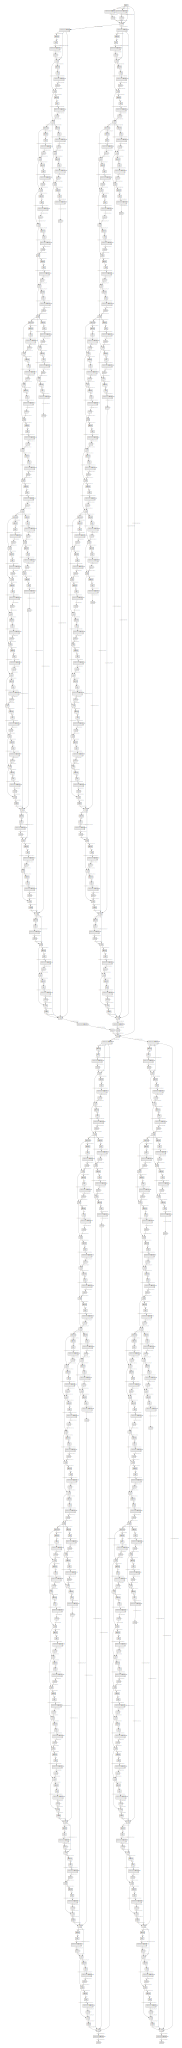

In [14]:
cpr_model

In [15]:
cpr_model.save(os.path.join(opt["env"]["saveDir"], "viz"))

In [3]:
model = create_model("cpr")

/home/kartmann/Documents/program/part-affinity/src/model/helper.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)
/home/kartmann/Documents/program/part-affinity/src/model/helper.py:13: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0.1)
